<a href="https://colab.research.google.com/github/vaishnavipatil29/NN_DL_Lab/blob/main/Spring_22_NNDL_Lab_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 8 : Autoencoders

Name : 

Roll Number : 

Reference : 
 1. https://towardsdatascience.com/how-to-make-an-autoencoder-2f2d99cd5103
 2. https://www.geeksforgeeks.org/contractive-autoencoder-cae/
 3. https://blog.keras.io/building-autoencoders-in-keras.html

#see if all have encoder, encoded and all properly

#Problem 1 :  Demonstrate the working principle of Autoencoder. (pytorch/keras/tensorflow)
Observation to be demonstrated
1. Use suitable data to demonstrate the same. (MNIST fashion/digit data can be
used)
2. Train the auto encoder with clean image and test using noisy image (you can add
some random Gaussian noise). Demonstrate the effect with/without dropout.
3. CNN with output Sigmoid layer and MSE loss can be used. Justify why Sigmoid is fine in this case.
4. Train the network with both clean and noisy version of image where the labeled
image is clean one (that given output to the autoencoder). Demonstrate output
of the autoencoder with noisy image (that is generated separately not used in
training).

##Write down the Objectives, Hypothesis and Experimental description for the above problem


## Programming : 
  Please write a program to demonstrate the same

In [ ]:
#------------Imports----------------------#
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np


In [ ]:
#Load the mnist digit Data
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) #28x28 = 784 : Flatten the images
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


print("Train : ", x_train.shape)
print("Test : ", x_test.shape)



Train :  (60000, 784)
Test :  (10000, 784)


In [ ]:
x_train[0]

## Part - 1 : First let's try different Autoencoder models on our data

### 1. Single fully-connected neural layer as encoder and as decoder

In [ ]:
import keras
from keras import layers

#---------------------------Latent Size----------------#
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))

#---------------Encoder--------------------#
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
encoder = keras.Model(input_img, encoded)


#----------------Decoder-------------------#
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)
# Retrieve the last layer of the autoencoder model
# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)
decoder_layer = autoencoder.layers[-1]


#-----------------Give Input-----------#
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))



Epoch 1/50
235/235 [==============================] - 4s 6ms/step - loss: 0.2746 - val_loss: 0.1909
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1707 - val_loss: 0.1533
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1438 - val_loss: 0.1336
Epoch 4/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1285 - val_loss: 0.1214
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1184 - val_loss: 0.1131
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1115 - val_loss: 0.1076
Epoch 7/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1067 - val_loss: 0.1034
Epoch 8/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1031 - val_loss: 0.1004
Epoch 9/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1002 - val_loss: 0.0979
Epoch 10/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0981 - val_loss: 0.0961

Testing

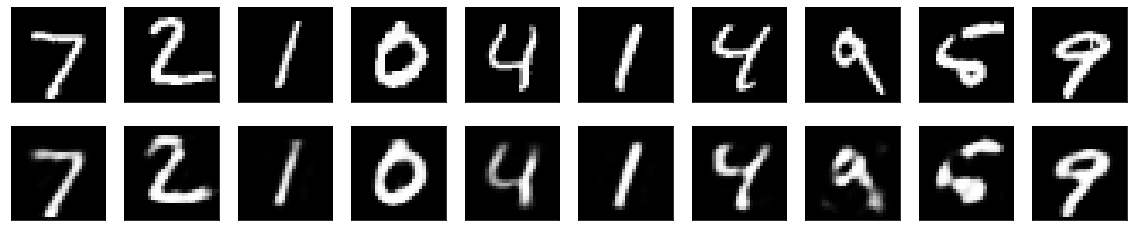

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
autoencoder.save('/content/drive/MyDrive/autoencoder_1')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/autoencoder_1/assets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Adding a sparsity constant

In [ ]:
import keras
from keras import layers
from keras import regularizers


#---------------------------Latent Size----------------#
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))

#---------------Encoder--------------------#
# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
encoder = keras.Model(input_img, encoded)


#----------------Decoder-------------------#
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)
# Retrieve the last layer of the autoencoder model
# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)
decoder_layer = autoencoder.layers[-1]


#-----------------Give Input-----------#
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))



Epoch 1/100
235/235 [==============================] - 2s 8ms/step - loss: 0.2847 - val_loss: 0.1962
Epoch 2/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1772 - val_loss: 0.1603
Epoch 3/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1520 - val_loss: 0.1426
Epoch 4/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1380 - val_loss: 0.1314
Epoch 5/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1285 - val_loss: 0.1233
Epoch 6/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1220 - val_loss: 0.1180
Epoch 7/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1173 - val_loss: 0.1140
Epoch 8/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1139 - val_loss: 0.1112
Epoch 9/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1114 - val_loss: 0.1090
Epoch 10/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1095 - val_lo

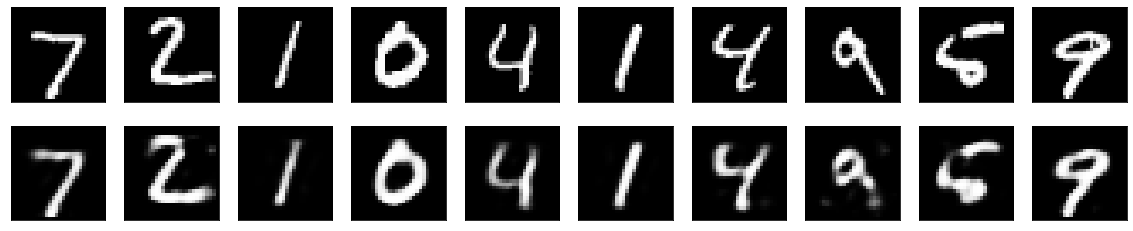

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)


# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
autoencoder.save('/content/drive/MyDrive/autoencoder_2')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/autoencoder_2/assets


sparsity of the encoded representations

In [ ]:
encoded_imgs.mean()

8.515477

In [ ]:
encoded_imgs = encoder.predict(x_test)
encoded_imgs.mean() #--------Model 2-----#

1.2676324

Deep Autoencoders

Without Dropouts

In [ ]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/100
235/235 [==============================] - 2s 7ms/step - loss: 0.2485 - val_loss: 0.1695
Epoch 2/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1535 - val_loss: 0.1407
Epoch 3/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1361 - val_loss: 0.1301
Epoch 4/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1271 - val_loss: 0.1224
Epoch 5/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1216 - val_loss: 0.1176
Epoch 6/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1164 - val_loss: 0.1124
Epoch 7/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1115 - val_loss: 0.1080
Epoch 8/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1079 - val_loss: 0.1054
Epoch 9/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1054 - val_loss: 0.1035
Epoch 10/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1035 - val_lo

In [ ]:
autoencoder.save('/content/drive/MyDrive/autoencoder_3')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/autoencoder_3/assets


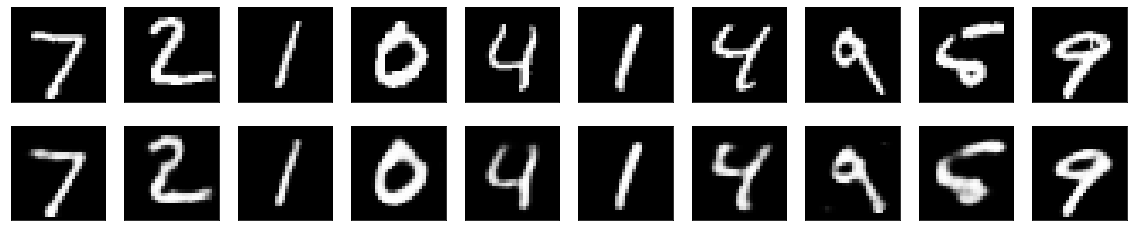

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


With dropouts

In [ ]:
from keras import layers
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dropout(0.5)(encoded)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dropout(0.5)(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dropout(0.5)(decoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dropout(0.5)(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/100
235/235 [==============================] - 2s 7ms/step - loss: 0.2969 - val_loss: 0.2386
Epoch 2/100
235/235 [==============================] - 1s 6ms/step - loss: 0.2359 - val_loss: 0.2110
Epoch 3/100
235/235 [==============================] - 1s 6ms/step - loss: 0.2208 - val_loss: 0.2005
Epoch 4/100
235/235 [==============================] - 1s 6ms/step - loss: 0.2147 - val_loss: 0.1949
Epoch 5/100
235/235 [==============================] - 1s 6ms/step - loss: 0.2109 - val_loss: 0.1919
Epoch 6/100
235/235 [==============================] - 1s 6ms/step - loss: 0.2081 - val_loss: 0.1893
Epoch 7/100
235/235 [==============================] - 2s 6ms/step - loss: 0.2056 - val_loss: 0.1860
Epoch 8/100
235/235 [==============================] - 1s 6ms/step - loss: 0.2037 - val_loss: 0.1839
Epoch 9/100
235/235 [==============================] - 1s 6ms/step - loss: 0.2021 - val_loss: 0.1826
Epoch 10/100
235/235 [==============================] - 2s 8ms/step - loss: 0.2008 - val_lo

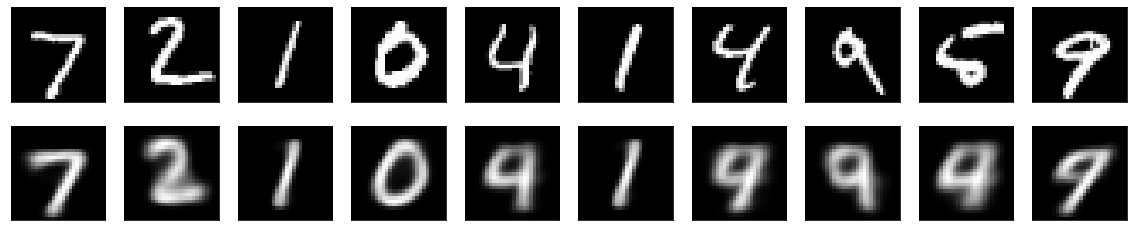

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
autoencoder.save('/content/drive/MyDrive/autoencoder_3_dropouts')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/autoencoder_3_dropouts/assets


## 4. CNN AE

In [ ]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


In [ ]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50, #More 50 epochs
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0891 - val_loss: 0.0879
Epoch 2/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0890 - val_loss: 0.0880
Epoch 3/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0890 - val_loss: 0.0886
Epoch 4/50
469/469 [==============================] - 5s 12ms/step - loss: 0.0889 - val_loss: 0.0879
Epoch 5/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0889 - val_loss: 0.0879
Epoch 6/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0889 - val_loss: 0.0880
Epoch 7/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0889 - val_loss: 0.0878
Epoch 8/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0888 - val_loss: 0.0877
Epoch 9/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0888 - val_loss: 0.0886
Epoch 10/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0888 - val_lo

In [ ]:
autoencoder.save('/content/drive/MyDrive/autoencoder_cnn')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/autoencoder_cnn/assets


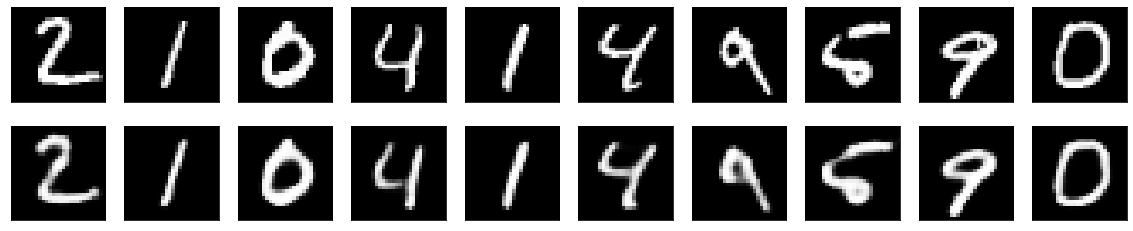

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


With Dropouts

In [ ]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [ ]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/50
469/469 [==============================] - 7s 13ms/step - loss: 0.2438 - val_loss: 0.1679
Epoch 2/50
469/469 [==============================] - 6s 13ms/step - loss: 0.1763 - val_loss: 0.1482
Epoch 3/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1655 - val_loss: 0.1394
Epoch 4/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1594 - val_loss: 0.1343
Epoch 5/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1554 - val_loss: 0.1301
Epoch 6/50
469/469 [==============================] - 6s 13ms/step - loss: 0.1524 - val_loss: 0.1272
Epoch 7/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1496 - val_loss: 0.1257
Epoch 8/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1480 - val_loss: 0.1245
Epoch 9/50
469/469 [==============================] - 6s 12ms/step - loss: 0.1469 - val_loss: 0.1239
Epoch 10/50
469/469 [==============================] - 6s 13ms/step - loss: 0.1459 - val_lo

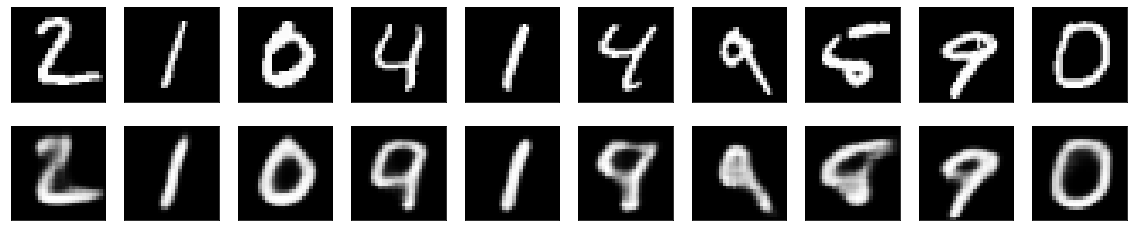

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## Inferences

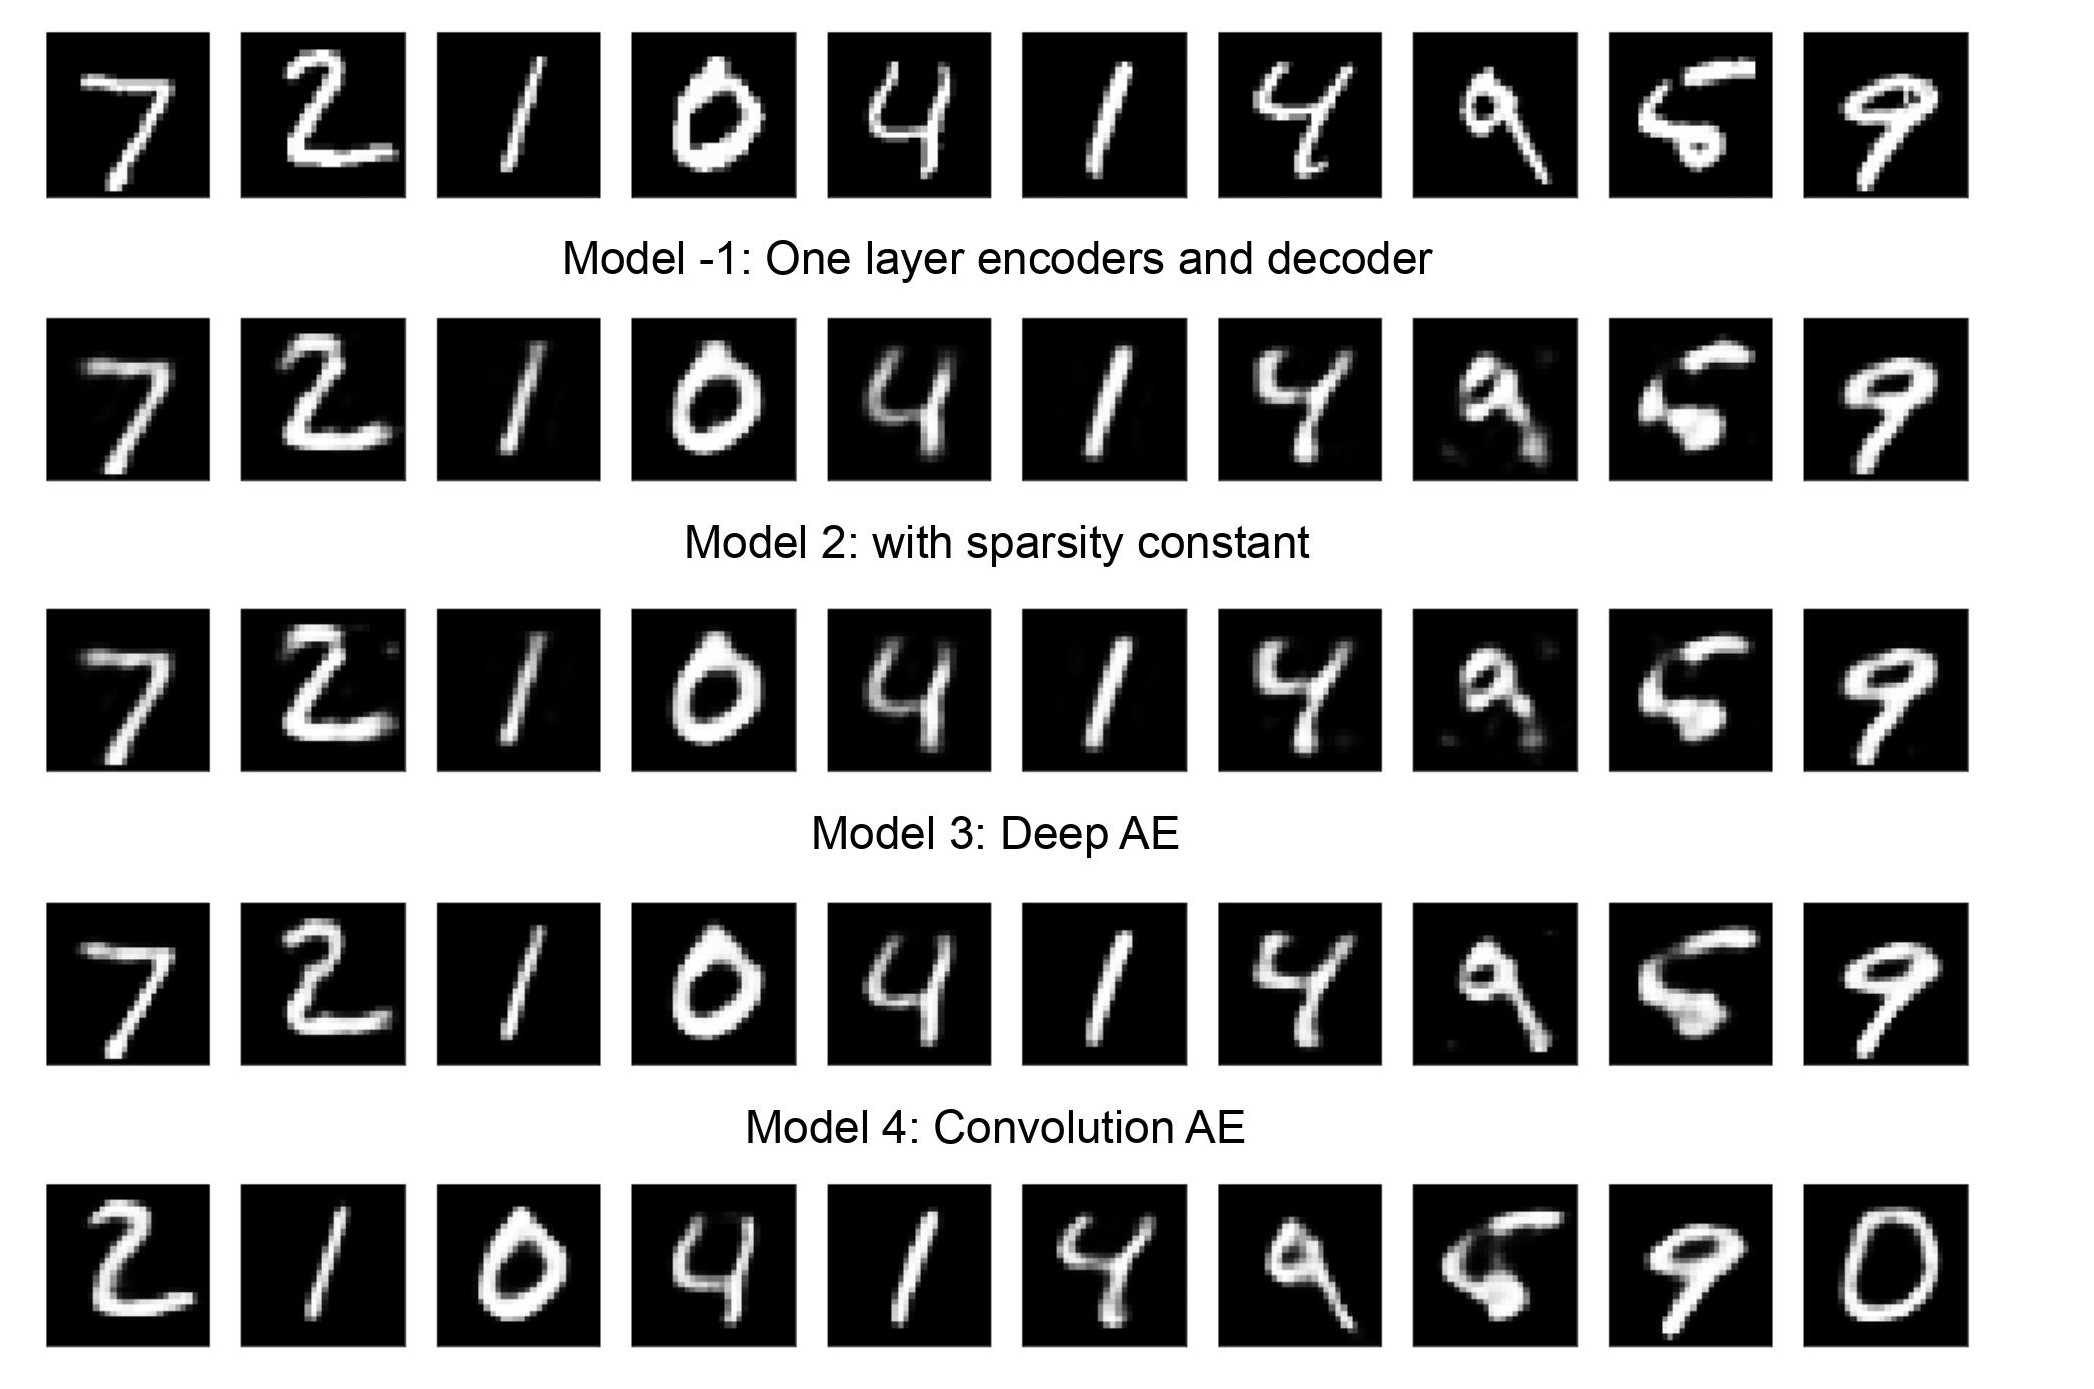

Results


Model | Training Loss | Testing Loss | Comments
--- | ---  | --- | ---
Single Layer AE | 0.0927 | 0.0916 | We are losing quite a bit of detail with this basic approach.Representations were only constrained by the size of the hidden layer (32).
 |   |  | So, hidden layer is learning an approximation of PCA (principal component analysis).
Sparsity constant | 0.096 | 0.095 | The decoded images are pretty similar to the previous model, the only significant difference being the sparsity of the encoded representations. 
| | | encoded_imgs.mean() yields a value 1.26 (over our 10,000 test images), whereas with the previous model the same quantity was 8.5. So our new model yields encoded representations that are more sparser.
Deep AE | 0.08 | 0.08 | The reconstructed images as well as loss are better than previous models.
CNN AE | 0.08 | 0.08 | The loss has converged significantly largely due to the higher entropic capacity of the encoded representation, 128 (8x4x4) dimensions vs. 32 previously. As seen, the reconstructed images are best in this case.



No significant improvement seen with using dropouts.

## Part 2 : Demonstrating results with Noisy Images

Model trained on clean images and tested on noisy images

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


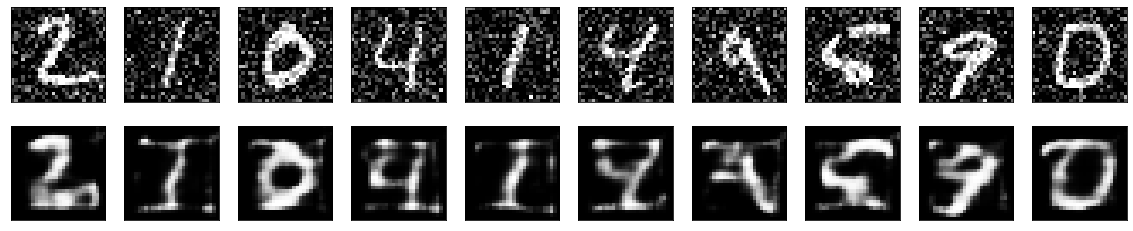

In [ ]:
noise_factor = 0.3

x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Training the AE with both clean and noisy image and give clean image as labelled output

In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [ ]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])


Epoch 1/100
469/469 [==============================] - 8s 15ms/step - loss: 0.1695 - val_loss: 0.1180
Epoch 2/100
469/469 [==============================] - 6s 14ms/step - loss: 0.1138 - val_loss: 0.1093
Epoch 3/100
469/469 [==============================] - 6s 14ms/step - loss: 0.1078 - val_loss: 0.1050
Epoch 4/100
469/469 [==============================] - 6s 14ms/step - loss: 0.1049 - val_loss: 0.1028
Epoch 5/100
469/469 [==============================] - 7s 14ms/step - loss: 0.1029 - val_loss: 0.1017
Epoch 6/100
469/469 [==============================] - 6s 14ms/step - loss: 0.1017 - val_loss: 0.1004
Epoch 7/100
469/469 [==============================] - 7s 14ms/step - loss: 0.1006 - val_loss: 0.0994
Epoch 8/100
469/469 [==============================] - 6s 14ms/step - loss: 0.0999 - val_loss: 0.0990
Epoch 9/100
469/469 [==============================] - 7s 14ms/step - loss: 0.0992 - val_loss: 0.0985
Epoch 10/100
469/469 [==============================] - 6s 14ms/step - loss: 0.098

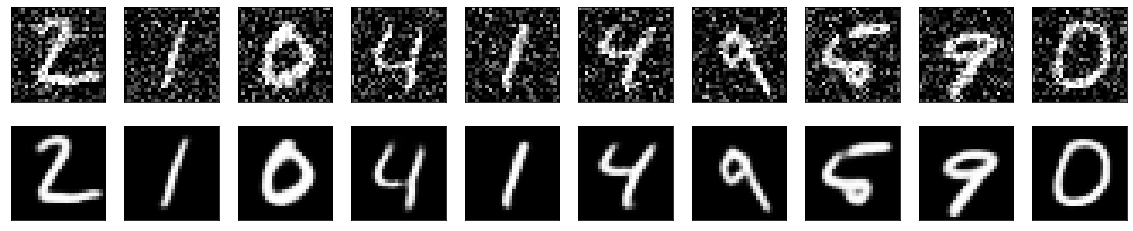

In [ ]:
noise_factor = 0.3 #diff output than it is trained

x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Significant improvement is seen 

## Inferences and Conclusion : State all the key observations and conclusion

#Problem 2 : Demonstrate the importance of different regularization techniques to train an Autoencoder. (pytorch/keras/tensorflow)

Observation to be demonstrated
1. Use suitable data and auto-encoder architecture to demonstrate the same. (MNIST
fashion/digit data can be used)
1. Implement weight decaying, sparse and contractive regularization functions and train the autoencoder using the same and show the significance of using
them in autoencoder training

##Write down the Objectives, Hypothesis and Experimental description for the above problem


## Programming : 
  Please write a program to demonstrate the same

In [ ]:
## Write your code here

## Inferences and Conclusion : State all the key observations and conclusion